In [1]:
import tensorflow as tf

with tf.name_scope("a_name_scope"):
    initializer = tf.constant_initializer(value=1)
    var1 = tf.get_variable(name='var1', shape=[1], dtype=tf.float32, initializer=initializer)
    var2 = tf.Variable(name='var2', initial_value=[2], dtype=tf.float32)
    var21 = tf.Variable(name='var2', initial_value=[2.1], dtype=tf.float32)
    var22 = tf.Variable(name='var2', initial_value=[2.2], dtype=tf.float32)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(var1.name)        # var1:0
    print(sess.run(var1))   # [ 1.]
    print(var2.name)        # a_name_scope/var2:0
    print(sess.run(var2))   # [ 2.]
    print(var21.name)       # a_name_scope/var2_1:0
    print(sess.run(var21))  # [ 2.0999999]
    print(var22.name)       # a_name_scope/var2_2:0
    print(sess.run(var22))  # [ 2.20000005]

var1:0
[ 1.]
a_name_scope/var2:0
[ 2.]
a_name_scope/var2_1:0
[ 2.0999999]
a_name_scope/var2_2:0
[ 2.20000005]


可以看出使用 tf.Variable() 定义的时候, 虽然 name 都一样, 但是为了不重复变量名, Tensorflow 输出的变量名并不是一样的. 所以, 本质上 var2, var21, var22 并不是一样的变量. 而另一方面, 使用tf.get_variable()定义的变量不会被tf.name_scope()当中的名字所影响.

## tf.variable_scope() 
如果想要达到重复利用变量的效果, 我们就要使用 tf.variable_scope(), 并搭配 tf.get_variable() 这种方式产生和提取变量. 不像 tf.Variable() 每次都会产生新的变量, tf.get_variable() 如果遇到了同样名字的变量时, 它会单纯的提取这个同样名字的变量(避免产生新变量). 而在重复使用的时候, 一定要在代码中强调 scope.reuse_variables(), 否则系统将会报错, 以为你只是单纯的不小心重复使用到了一个变量.

In [2]:
with tf.variable_scope("a_variable_scope") as scope:
    initializer = tf.constant_initializer(value=3)
    var3 = tf.get_variable(name='var3', shape=[1], dtype=tf.float32, initializer=initializer)
    scope.reuse_variables()
    var3_reuse = tf.get_variable(name='var3',)
    var4 = tf.Variable(name='var4', initial_value=[4], dtype=tf.float32)
    var4_reuse = tf.Variable(name='var4', initial_value=[4], dtype=tf.float32)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(var3.name)            # a_variable_scope/var3:0
    print(sess.run(var3))       # [ 3.]
    print(var3_reuse.name)      # a_variable_scope/var3:0
    print(sess.run(var3_reuse)) # [ 3.]
    print(var4.name)            # a_variable_scope/var4:0
    print(sess.run(var4))       # [ 4.]
    print(var4_reuse.name)      # a_variable_scope/var4_1:0
    print(sess.run(var4_reuse)) # [ 4.]

a_variable_scope/var3:0
[ 3.]
a_variable_scope/var3:0
[ 3.]
a_variable_scope/var4:0
[ 4.]
a_variable_scope/var4_1:0
[ 4.]


## RNN应用例子 
RNN 例子的代码在[这里](https://github.com/MorvanZhou/tutorials/blob/master/tensorflowTUT/tf22_scope/tf22_RNN_scope.py), 整个 RNN 的结构已经在这里定义好了. 在 training RNN 和 test RNN 的时候, RNN 的 time_steps 会有不同的取值, 这将会影响到整个 RNN 的结构, 所以导致在 test 的时候, 不能单纯地使用 training 时建立的那个 RNN. 但是 training RNN 和 test RNN 又必须是有同样的 weights biases 的参数. 所以, 这时, 就是使用 reuse variable 的好时机.

首先定义training 和 test 的不同参数.

    class TrainConfig:
        batch_size = 20
        time_steps = 20
        input_size = 10
        output_size = 2
        cell_size = 11
        learning_rate = 0.01


    class TestConfig(TrainConfig):
        time_steps = 1

    train_config = TrainConfig()
    test_config = TestConfig()
然后让 train_rnn 和 test_rnn 在同一个 tf.variable_scope('rnn') 之下. 并且定义 scope.reuse_variables(), 使我们能把 train_rnn 的所有 weights, biases 参数全部绑定到 test_rnn 中. 这样, 不管两者的 time_steps 有多不同, 结构有多不同, train_rnn W, b 参数更新成什么样, test_rnn 的参数也更新成什么样.

    with tf.variable_scope('rnn') as scope:
        sess = tf.Session()
        train_rnn = RNN(train_config)
        scope.reuse_variables()
        test_rnn = RNN(test_config)
        sess.run(tf.global_variables_initializer())

# Batch Normalization
Batch normalization 是一种解决深度神经网络层数太多, 而没办法有效前向传递(forward propagate)的问题. 因为每一层的输出值都会有不同的 均值(mean) 和 方差(deviation), 所以输出数据的分布也不一样, 如下图, 从左到右是每一层的输入数据分布, 上排的没有 Batch normalization, 下排的有 Batch normalization.
![image](https://morvanzhou.github.io/static/results/tensorflow/5_13_01.png)
我们以前说过, 为了更有效的学习数据, 我们会对数据预处理, 进行 normalization (请参考我制作的 为什么要特征标准化). 而现在请想象, 我们可以把 “每层输出的值” 都看成 “后面一层所接收的数据”. 对每层都进行一次 normalization 会不会更好呢? 这就是 Batch normalization 方法的由来.

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


ACTIVATION = tf.nn.relu # 每一层都使用 relu 
N_LAYERS = 7            # 一共7层隐藏层
N_HIDDEN_UNITS = 30     # 每个层隐藏层有 30 个神经元

In [5]:
def fix_seed(seed=1):
    # reproducible
    np.random.seed(seed)
    tf.set_random_seed(seed)

In [10]:
def plot_his(inputs,inputs_norm):
    # plot histogram for the inputs of every layer
#     enumerate(iterable[, start]) -> iterator for index, value of iterable
    for j,all_inputs in  enumerate([inputs,inputs_norm]):
        for i,input in enumerate(all_inputs):
            plt.subplot(2, len(all_inputs), j*len(all_inputs)+(i+1))
            plt.cla() #clear current axes
            if i==0:
                the_range = (-7,10)
            else:
                the_range = (-1,1)
            plt.hist(input.ravel(),bins=15,range=the_range,color='#FF5733') #bins 柱状图条数
            plt.yticks(())
            if j == 1:
                plt.xticks(the_range)
            else:
                plt.xticks(())
            ax = plt.gca()
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
        plt.title("%s normalizing" % ("Without" if j == 0 else "With"))
#         plt.tight_layout()
        plt.draw()
        plt.pause(0.01)

In [7]:
def built_net(xs,ys,norm):
    def add_layer(inputs,in_size,out_size,activation_function=None,norm=False):
         # weights and biases (bad initialization for this case)
        Weights = tf.Variable(tf.random_normal([in_size, out_size], mean=0., stddev=1.))
        biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
        
        # fully connected product
        Wx_plus_b = tf.matmul(inputs, Weights) + biases
        
        #normalize fully connected product
        if norm:
            # Batch Normalize
            fc_mean,fc_var = tf.nn.moments(
                Wx_plus_b,
                axes=[0]
                # the dimension you wanna normalize, here [0] for batch
                            # for image, you wanna do [0, 1, 2] for [batch, height, width] but not channel
            )
            scale = tf.Variable(tf.ones([out_size]))
            shift = tf.Variable(tf.zeros([out_size]))
            epsilon = 0.001
            
            # apply moving average for mean and var when train on batch
            ema = tf.train.ExponentialMovingAverage(decay=0.5) # exponential moving average 的 decay 度
            def mean_var_with_update():
                ema_apply_op = ema.apply([fc_mean, fc_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(fc_mean), tf.identity(fc_var)
            mean, var = mean_var_with_update()   # 根据新的 batch 数据, 记录并稍微修改之前的 mean/var
# 如果你是使用 batch 进行每次的更新, 那每个 batch 的 mean/var 都会不同, 
# 所以我们可以使用 moving average 的方法记录并慢慢改进 mean/var 的值. 
# 然后将修改提升后的 mean/var 放入 tf.nn.batch_normalization(). 
# 而且在 test 阶段, 我们就可以直接调用最后一次修改的 mean/var 值进行测试, 而不是采用 test 时的 fc_mean/fc_var.
            Wx_plus_b = tf.nn.batch_normalization(Wx_plus_b, mean, var, shift, scale, epsilon)
            # similar with this two steps:
            # Wx_plus_b = (Wx_plus_b - fc_mean) / tf.sqrt(fc_var + 0.001)
            # Wx_plus_b = Wx_plus_b * scale + shift
        # activation
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)
        return outputs
    fix_seed(1)
    
    if norm:
        # BN for the first input
        fc_mean, fc_var = tf.nn.moments(
            xs,
            axes=[0],
        )
        scale = tf.Variable(tf.ones([1]))
        shift = tf.Variable(tf.zeros([1]))
        epsilon = 0.001
        # apply moving average for mean and var when train on batch
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        def mean_var_with_update():
            ema_apply_op = ema.apply([fc_mean, fc_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(fc_mean), tf.identity(fc_var)
        mean, var = mean_var_with_update()
        xs = tf.nn.batch_normalization(xs, mean, var, shift, scale, epsilon)
    # record inputs for every layer
    layers_inputs = [xs]
    
    #build hidden layers
    for l_n in range(N_LAYERS):
        layer_input = layers_inputs[l_n]
        in_size = layers_inputs[l_n].get_shape()[1].value

        output = add_layer(
            layer_input,    # input
            in_size,        # input size
            N_HIDDEN_UNITS, # output size
            ACTIVATION,     # activation function
            norm,           # normalize before activation
        )
        layers_inputs.append(output)    # add output for next run

    #build output layer
    prediction = add_layer(layers_inputs[-1],30,1,activation_function=None)

    cost = tf.reduce_mean(tf.reduce_sum(tf.square(ys-prediction),reduction_indices =[1]))
    train_op = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
    return [train_op,cost,layers_inputs]


C:\Users\Ruofan\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Ruofan\Anaconda3\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


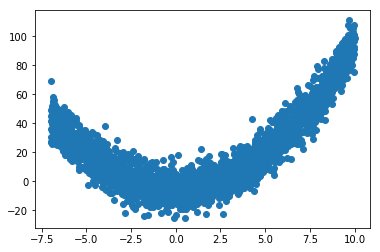

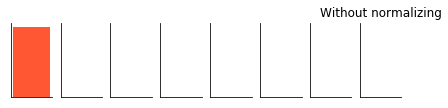

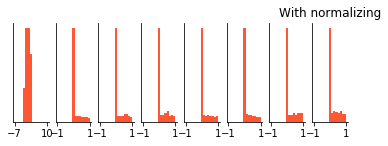

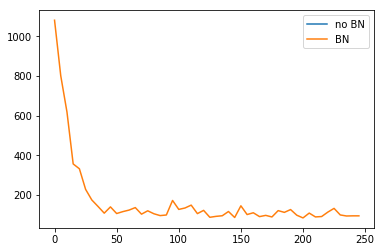

In [11]:
# make up data
fix_seed(1)
x_data = np.linspace(-7,10,2500)[:,np.newaxis]
np.random.shuffle(x_data)
noise = np.random.normal(0,8,x_data.shape)
y_data = x_data**2 -5 + noise

plt.scatter(x_data,y_data)
# plt.show()

xs = tf.placeholder(tf.float32,[None,1])
ys = tf.placeholder(tf.float32,[None,1])

train_op,cost,layers_inputs = built_net(xs,ys,norm=False)
train_op_norm, cost_norm, layers_inputs_norm = built_net(xs, ys, norm=True) # with BN

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#record cost
cost_his = []
cost_his_norm = []
record_step =5

# plt.ion()
plt.figure(figsize=(7,3))
for i in range(250):
    if i == 249:
        all_inputs, all_inputs_norm = sess.run([layers_inputs, layers_inputs_norm], feed_dict={xs: x_data, ys: y_data})
        plot_his(all_inputs, all_inputs_norm)

    #train on batch
    sess.run([train_op,train_op_norm],feed_dict={xs: x_data[i:2500:250], ys: y_data[i:2500:250]})

    if i%record_step == 0:
        # record cost
        cost_his.append(sess.run(cost, feed_dict={xs: x_data, ys: y_data}))
        cost_his_norm.append(sess.run(cost_norm, feed_dict={xs: x_data, ys: y_data}))

# plt.ioff()
plt.figure()
plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his), label='no BN')     # no norm
plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his_norm), label='BN')   # norm
plt.legend()
plt.show()

# Tensorflow 2017 更新
[github](https://github.com/MorvanZhou/Tensorflow-Tutorial)
[TF's docs](https://www.tensorflow.org/api_docs/python/)
simplify:
* add_layer()
old style:
    def add_layer(inputs, in_size, out_size, activation_function=None):
        Weights = tf.Variable(tf.random_normal([in_size, out_size]))
        biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
        Wx_plus_b = tf.matmul(inputs, Weights) + biases
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)
        return outputs
 new ver:
     l1 = tf.layers.dense(xs,10,tf.nn.relu)
* loss:
old style:
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys-prediction), reduction_indices=[1]))
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),
                                              reduction_indices=[1]))       # loss
new ver:
    loss = tf.losses.mean_squared_error(ys,pred)
    cross_entropy = tf.losses.softmax_cross_entropy(labels=ys,logits=pred)
    
* CNN:
old:
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
new:
    conv1=tf.layers.conv2d(
        inputs=image,
        filters=16, # filters: 卷积核个数。相当于output_size
        kernel_size=5, #kernel_size:卷积核大小，如[5，5].如果长宽相等，也可以直接设置为一个数，如kernel_size=5
        strides=1,
        padding='same',
        activation=tf.nn.relu
    )
    pool1 = tf.layers.max_pooling2d(
        conv1,
        pool_size=2,
        strides=2,
    )